In [2]:
import numpy as np
import os

from scipy.spatial import distance
import pandas as pd
import matplotlib.pyplot as plt    
import networkx as nx
import copy
from scipy import stats
from copy import deepcopy
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D


# Code testing for Strahler number

# How to determine Strahler number on a directed graph for a stream network

Consider a tree like structure as an example from https://stackoverflow.com/questions/29202822/how-to-determine-strahler-number-on-a-directed-graph-for-a-stream-network

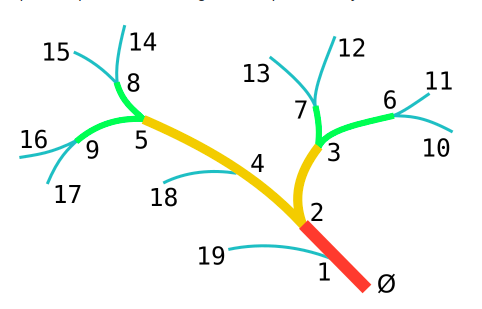

In [12]:


def test_G():
    
    # edge list with strahler number at last column
    # test case
    # st_strahl element: (from_node, to_node, expected order or strahler number)
    st_strahl  = [#(1,0,4),
                  (2, 1, 4),
    (3, 2, 3),
    (4, 2, 3),
    (5, 4, 3),
    (6, 3, 2),
    (7, 3, 2),
    (8, 5, 2),
    (9, 5, 2),
    (10, 6, 1),
    (11, 6, 1),
    (12, 7, 1),
    (13, 7, 1),
    (14, 8, 1),
    (15, 8, 1),
    (16, 9, 1),
    (17, 9, 1),
    (18, 4, 1),
    (19, 1, 1)]


    # we need to include 1 as node in the beginning
    nodes_list = [1]
    for elem in st_strahl:
        nodes_list.append(elem[0])

    edge_list = []
    for elem in st_strahl:
        edge_list.append(  (elem[0],elem[1]) )


    # expected order is list of all stahler number
    expected_order = []
    for elem in st_strahl:
        expected_order.append(elem[2]) 

    # create graph


    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    return G


In [9]:
G=test_G()

# check which node is root node
root = list(reversed(list(nx.topological_sort(G))))[0]#next(iter(list(reversed(list(nx.topological_sort(G))))))
root

0

In [10]:
# check edges
G.edges()

OutEdgeView([(1, 0), (2, 1), (3, 2), (4, 2), (5, 4), (6, 3), (7, 3), (8, 5), (9, 5), (10, 6), (11, 6), (12, 7), (13, 7), (14, 8), (15, 8), (16, 9), (17, 9), (18, 4), (19, 1)])

In [3]:
# upstream refers to all the directed links going from all the tributaries/leaves to the main basin/mouth 
# if there is a case where the directed arrow goes from the child to a parent we take the definition of upstream.
# for the case of https://stackoverflow.com/questions/29202822/how-to-determine-strahler-number-on-a-directed-graph-for-a-stream-network
# we take upstream. 

def strahler_number_upstream(node):
    # -- If the node is a leaf (has no children), its Strahler number is one.
    # https://stackoverflow.com/questions/29202822/how-to-determine-strahler-number-on-a-directed-graph-for-a-stream-network
    if G.in_degree(node)==0:
        return 1
    
    # If a node has only one child, it is assigned the strahler number of its child.
    # see http://selezovikj.blogspot.com/2011/11/strahler-number-of-binary-tree.html
    elif G.in_degree(node)==1:
        
        child = list((G.in_edges(node)))[0][0]
        
        return strahler_number_upstream(child)
    
    elif G.in_degree(node)>=2:
        children = [edge[0] for edge in list(G.in_edges(node))]
        strahler_order = list(map(strahler_number_upstream,children))
        #If the node has one child with Strahler number i, 
        #            -- and all other children have Strahler numbers less than i, 
        #            -- then the Strahler number of the node is i again.
        if min(strahler_order) < max(strahler_order):
            return max(strahler_order)

        #-- If the node has two or more children with Strahler number i, 
        #-- and no children with greater number, 
        #-- then the Strahler number of the node is i + 1.
        if min(strahler_order) == max(strahler_order):
            return max(strahler_order) + 1 



In [14]:
%%time
strahler_dict = {}
G = test_G()        
for node in list(G.nodes()):
    strahler_dict[node] = strahler_number_upstream(node)
strahler_dict        


CPU times: user 2.93 ms, sys: 0 ns, total: 2.93 ms
Wall time: 2.94 ms


{1: 4,
 2: 4,
 3: 3,
 4: 3,
 5: 3,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1}

In [4]:
# downstream refers to directed arrow links in a tree/river going from the single main source to its tributaries

# for neurons of zebrafish, since the directed arrow goes from soma source/parent to child we take downstream defn.
def strahler_number_downstream(node):
    # -- If the node is a leaf (has no children), its Strahler number is one.
    # https://stackoverflow.com/questions/29202822/how-to-determine-strahler-number-on-a-directed-graph-for-a-stream-network
    if G.out_degree(node)==0:
        return 1
    
    # If a node has only one child, it is assigned the strahler number of its child.
    # see http://selezovikj.blogspot.com/2011/11/strahler-number-of-binary-tree.html
    elif G.out_degree(node)==1:
        
        child = list((G.out_edges(node)))[0][1]
        
        return strahler_number_downstream(child)
    
    elif G.out_degree(node)>=2:
        children = [edge[1] for edge in list(G.out_edges(node))] # small difference here wrt "upstream" definition
        strahler_order = list(map(strahler_number_downstream,children))
        #If the node has one child with Strahler number i, 
        #            -- and all other children have Strahler numbers less than i, 
        #            -- then the Strahler number of the node is i again.
        if min(strahler_order) < max(strahler_order):
            return max(strahler_order)

        #-- If the node has two or more children with Strahler number i, 
        #-- and no children with greater number, 
        #-- then the Strahler number of the node is i + 1.
        if min(strahler_order) == max(strahler_order):
            return max(strahler_order) + 1 



In [5]:
def get_neuron_graph(neuron_name):
    #neuron_name = "T_16119_13_1"
    fname = "./mapzebrain - Aligned neurons dataset/"+neuron_name+".swc"

    neuron = np.loadtxt(fname)
    
    # source nodes
    source = neuron[1:, -1].astype("int")
    #print(len(source))

    # target nodes(actually neurites)
    target = neuron[1:, 0].astype("int")
    
    initial = min(np.concatenate((source,target)))
    final = max(np.concatenate((source,target)))
    nodes = neuron[:,0]#list(range(initial,final+1))
    
    
    nodes_list = []
    for i in nodes:
        i_node_row = neuron[neuron[:,0]==i][0] # using [0] removes double brackets
        #print(i_node_row)
        x = i_node_row[2]
        y = i_node_row[3]
        z = i_node_row[4]
        
       
        nodes_list.append((i,{"pos":(x,y,z),"radius":i_node_row[-2]  }))
        
    edge_list = []
    for i,j in zip(source, target):
        edge_list.append( (i,j) )
    
    global G
    G = nx.DiGraph()

    # Add all the nodes to the graph
    G.add_nodes_from(nodes_list)
    # Add all the edges to the graph
    G.add_edges_from(edge_list)
    
    return G



In [ ]:
G = get_neuron_graph("T_161121_HuCxBG_8_3")#("T_190718_13_1")
strahler_dict = {}        
for node in list(G.nodes()):
    strahler_dict[int(node)] = strahler_number_downstream(node)
strahler_dict        


# store the dataset with strahler numbering as the last column


In [ ]:
import re


def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

In [ ]:


if not os.path.exists("./mapzebrain - Aligned neurons dataset with strahler_lastcolumn/"):
      
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs("./mapzebrain - Aligned neurons dataset with strahler_lastcolumn/")
    
    
file_path = "./mapzebrain - Aligned neurons dataset/"
file_list=[f for f in sorted_alphanumeric(os.listdir(file_path)) if f.endswith('.swc')
                    and os.path.isfile(os.path.join(file_path, f))]
    

def add_strahler_to_swc(swc_file):
    neuron_name = swc_file[:-4]
    #print(neuron_name)
    G = get_neuron_graph(neuron_name)
    # G is global variable here
    
    strahler_dict = {}        
    for node in list(G.nodes()):
        strahler_dict[node] = strahler_number_downstream(node)

        
    #strahler_dict        
    neuron_data = np.loadtxt(file_path+swc_file)
    
    correct_strahler_order = np.array([ strahler_dict[ neuron_data[i,0] ] for i in range(len(neuron_data)) ])
    
    # add the strahler number column at the end of neuron data
    neuron_data2 = np.c_[neuron_data,correct_strahler_order]# np.hstack( (neuron_data, correct_strahler_order.T) )
    #print(neuron_data2.shape)
    np.savetxt("./mapzebrain - Aligned neurons dataset with strahler_lastcolumn/%s"%swc_file,neuron_data2,
                   fmt=["%d","%d","%.9f","%.9f","%.9f","%.5f","%d","%d"] )
    G.clear() # remove all nodes and edges
        
i=0    
for swc_file in file_list:
    #print(swc_file)
    add_strahler_to_swc(swc_file)
    print(i)
    i+=1

        

# store only the dataset with strahler number = 1 and only the first row which belongs to soma.


In [ ]:

if not os.path.exists("./strhl_num_1_dataset/"):
      
    # if the demo_folder directory is not present 
    # then create it.
    os.makedirs("./strhl_num_1_dataset/")

file_path = "./mapzebrain - Aligned neurons dataset with strahler_lastcolumn/"
file_list=[f for f in sorted_alphanumeric(os.listdir(file_path)) if f.endswith('.swc')
                    and os.path.isfile(os.path.join(file_path, f))]

i=0
for file in file_list:
    neuron_data = np.loadtxt(file_path+file)
    soma = neuron_data[0,:]
    endpoints = neuron_data[neuron_data[:,-1]==1]

    neuron_data2 = np.vstack( (soma, endpoints) )
    np.savetxt("./strhl_num_1_dataset/%s"%file,neuron_data2,
                       fmt=["%d","%d","%.9f","%.9f","%.9f","%.5f","%d","%d"] )
    print(i)
    i+=1



# Compute threshold value to seperate out dendrites and axon terminals for each neuron

In [10]:
neuron_names = [file[:-4] for file in file_list]

In [27]:
def compute_thresh_soma_neurite_dist_sn1(neuron_names):
    
    thresh_value = []
    #neuron_names_list = []
    freq_vector_list = []
    bin_edges_list = []

    for name in neuron_names:
        b =np.loadtxt("./strhl_num_1_dataset/"+name+".swc")
        soma_b = b[0,2:5]
        neurites_b = b[1:,2:5]

        y = (np.array([distance.euclidean(soma_b,neurites_b[i]) for i in range(len(neurites_b))]))

        bins = np.histogram_bin_edges(y,bins="auto")
        freq = np.array(plt.hist(y,bins=bins))[0]
        
        bin_edges_list.append(list(bins))
        freq_vector_list.append(list(freq.astype(int)))
        
        
        #print(bins)
        #print(freq)
        plt.close()

        # compute threshold value
        new_freq = deepcopy(freq[1:len(freq)-1])
        index = np.argmin(new_freq)+1
        
        thresh_value.append( (bins[index]+bins[index+1])/2 ) # mean doesn't seems to be a good candidate here

    return freq_vector_list, bin_edges_list, thresh_value


In [21]:
freq_vector, bin_edges, thresh_vals_sn1 = compute_thresh_soma_neurite_dist_sn1(neuron_names)

In [ ]:
df = pd.DataFrame({"neuron_names": neuron_names,"thresh_vals_sn1":thresh_vals_sn1})#"freq_vector":freq_vector,"bin_edge":bin_edges, 
df

In [30]:
df.to_csv("thresh_vals_neurons.csv", index=False)

# Visualize the soma - neurites distribution for a given neuron and observe the location of threshold value

In [31]:
df = pd.read_csv("thresh_vals_neurons.csv")

def plot_soma_neurite_dist(name,df):
    
    a =np.loadtxt("./mapzebrain - Aligned neurons dataset/"+name+".swc")
    soma_a = a[0,2:5]
    neurites_a = a[1:,2:5]
    
    b =np.loadtxt("./strhl_num_1_dataset/"+name+".swc")
    soma_b = b[0,2:5]
    neurites_b = b[1:,2:5]
    
    x = (np.array([distance.euclidean(soma_a,neurites_a[i]) for i in range(len(neurites_a))]))
    y = (np.array([distance.euclidean(soma_b,neurites_b[i]) for i in range(len(neurites_b))]))

    thresh_value = df[df.neuron_names==name].thresh_vals_sn1.item()
        
    print(name)
    print(thresh_value)
     
    plt.figure(figsize=(13.5,5))
    
    plt.subplot(1,2,1)
    sns.histplot(x, kde=True)#, line_kws={"c":"green" })
    
    plt.xlabel("Distance btw. soma and all neurites")
    
    plt.subplot(1,2,2)
    sns.histplot(y, kde=True, color="red")#, line_kws={"c":"green" })
    
    plt.axvline(x=thresh_value, color="green",label="threshold value = %.3f"%thresh_value)
    plt.legend(loc="best")
    plt.xlabel("Distance btw. soma and neurites\n with strahler number 1")
    plt.show()


T_16119_13_1
80.19475583998245


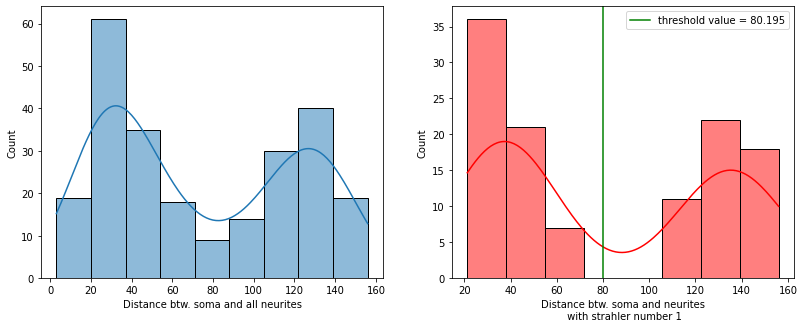

In [32]:
# bimodal T_16119_13_1, U

plot_soma_neurite_dist("T_16119_13_1",df)


T_161121_HuCxBG_8_3
70.99269478853381


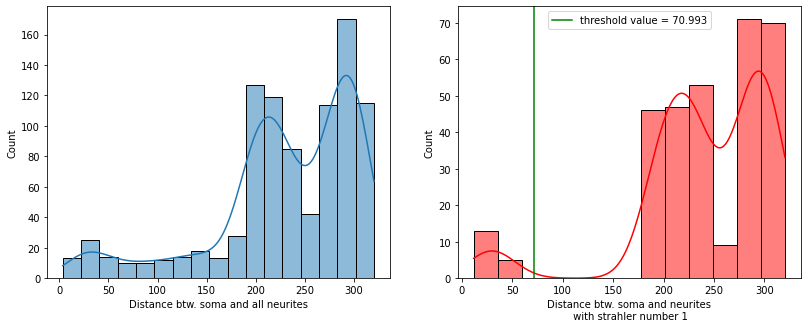

In [33]:
# bimodal T_16119_13_1, U

plot_soma_neurite_dist("T_161121_HuCxBG_8_3",df)


# Visualize bimodal neuron "T_16119_13_1" with dendrites and axon terminals in seperate colors

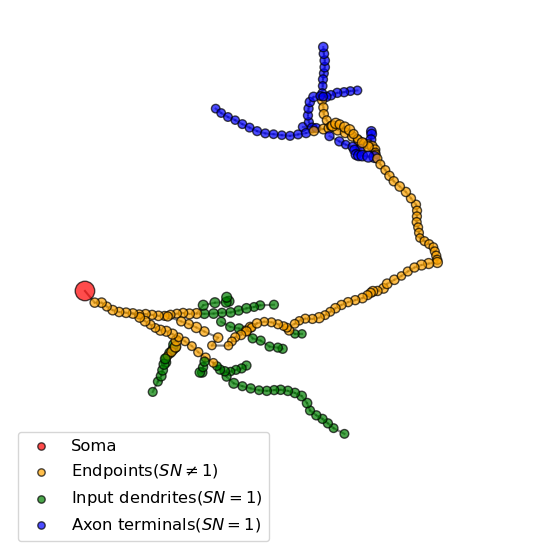

In [34]:

def network_plot_3D(G, angle, strahler_dict,name, save=False, elev=None, azim=None):
    df = pd.read_csv("thresh_vals_neurons.csv")
    thresh_val = df[df.neuron_names==name].thresh_vals_sn1.item()
    
    endpoints = np.loadtxt("./mapzebrain - Aligned neurons dataset/"+name+".swc")
    
    soma_pos = endpoints[0,2:5]


    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    radius_dict = nx.get_node_attributes(G, 'radius')
    radius_values = np.array(list(dict(radius_dict).values()))
    
    
    # Get number of nodes
    n = list(G.nodes)

    target = [list(G.edges)[i][1] for i in range(len(list(G.edges)))]

    
    colors=[]
    for key,value in strahler_dict.items():
        if key==1:
            colors.append("red")
        elif value==1:
            ind = list(endpoints[:,0]).index(key)
            endpoint_pos = endpoints[ind, 2:5]
            
            soma_neurite_distance = distance.euclidean(soma_pos, endpoint_pos)
            #print(soma_neurite_distance)
            #print(thresh_val)
            if soma_neurite_distance<=thresh_val:
                colors.append("green")
            else:
                colors.append("blue")
        else:
            colors.append("orange")
    

    # 3D network plot
    with plt.style.context(('default')):
        
        fig = plt.figure(figsize=(10,7))
        #ax = Axes3D(fig)
        ax = fig.gca(projection='3d')
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        xi, yi, zi = [],[],[]
        for key, value in pos.items():
            xi.append(value[0])
            yi.append(value[1])
            zi.append(value[2])
            
            
        ax.scatter(xi, yi, zi, c=colors, s=20+15*radius_values, edgecolors='k', alpha=0.7)
        
            
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        x,y,z = [],[],[]
        for i,j in enumerate(G.edges()):
            x=(np.array((pos[j[0]][0], pos[j[1]][0])) )
            y=(np.array((pos[j[0]][1], pos[j[1]][1])) )
            z=(np.array((pos[j[0]][2], pos[j[1]][2])) )
        
            # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)
        
    # Set the initial view
    #ax.view_init(30, angle)
    # labelling the scatter points
    ax.scatter([],[],[], c='red', s=28,edgecolors='k', alpha=0.7, label="Soma")
    ax.scatter([],[],[], c='orange', s=28,edgecolors='k', alpha=0.7, label=r"Endpoints($SN \neq 1$)")
    
    ax.scatter([],[],[], c='green', s=28,edgecolors='k', alpha=0.7, label="Input dendrites($SN = 1$)")
    ax.scatter([],[],[], c='blue', s=28,edgecolors='k', alpha=0.7, label="Axon terminals($SN = 1$)")
    
        
    ax.legend(loc="best", prop={'size':11.8})
    
    #ax.set_xlabel('$X$', fontsize=15, rotation=150)
    #ax.set_ylabel('$Y$', fontsize=15)
    #ax.set_zlabel('$Z$', fontsize=15, rotation=90)

    # Hide the axes
    ax.set_axis_off()
    
    # set elevation and azimuthal angle
    if elev!=None and azim!=None:
        #ele, azm =  113, -38
        ax.view_init(elev=elev, azim=azim) 

    if save is not False:
        plt.savefig(name+".png")
        plt.show()
        #plt.close('all')
    else:
        plt.show()
        
    return


# T_16119_13_1 Bimodal, 2 peaks
strahler_dict = {}
name = "T_16119_13_1"
G = get_neuron_graph(name)
for node in list(G.nodes()):
    strahler_dict[node] = strahler_number_downstream(node)
strahler_dict        


network_plot_3D(G, angle=0, strahler_dict=strahler_dict, name=name, save=False, elev=113, azim=-38 )


# Classification of SN=1 endpoints into dendrites and axon terminals folders for future construction of directed network

In [36]:
df = pd.read_csv("thresh_vals_neurons.csv")
threshold_dist = list(df.thresh_vals_sn1)

In [38]:
# common threshold distance for division = 50
#Differentiate neurites into axon terminals and dendrites(input) based on soma-neurites distance 
def extract_position(fname):
    neuron_data = np.loadtxt(fname)
    soma = neuron_data[0,:]#2:5 # considering only the positions/coordinates
    neurites = neuron_data[1:,:]
    return neurites,soma

def divide_neurites(threshold_dist): #threshold_dist is a list here
    
    file_path = "./strhl_num_1_dataset/"

    file_list=[f for f in sorted_alphanumeric(os.listdir(file_path)) if f.endswith('.swc')
                    and os.path.isfile(os.path.join(file_path, f))]

    n_neurons = len(file_list)
    
    cwd = os.getcwd()
    dir = os.path.join(cwd,"dendrites_axonTermials")
    if not os.path.exists(dir):
        os.mkdir(dir)
    dir = os.path.join(cwd,"dendrites_axonTermials","input_dendrites")
    if not os.path.exists(dir):
        os.mkdir(dir)
    dir = os.path.join(cwd,"dendrites_axonTermials","axon_terminals")
    if not os.path.exists(dir):
        os.mkdir(dir)
    
    for i in range(n_neurons):
        neurites, soma = extract_position(file_path+file_list[i])
        
        axon_terminals = []
        axon_terminals.append(soma)
        dendrites = []
        dendrites.append(soma)
        
        for j in range(len(neurites)):
            dist_neurites_soma = distance.euclidean(neurites[j,2:5],soma[2:5])
            if dist_neurites_soma<=threshold_dist[i]:
                dendrites.append(neurites[j,:])
            else:
                axon_terminals.append(neurites[j,:])
        
        axon_terminals = np.array(axon_terminals) # convert them to array      
        dendrites = np.array(dendrites)       
        
        np.savetxt("./dendrites_axonTermials/input_dendrites/%s"%file_list[i],dendrites[:,:-1],
                   fmt=["%d","%d","%.9f","%.9f","%.9f","%.5f","%d"] )    
        np.savetxt("./dendrites_axonTermials/axon_terminals/%s"%file_list[i],axon_terminals[:,:-1],
                   fmt=["%d","%d","%.9f","%.9f","%.9f","%.5f","%d"] )   # leave out the strahler number values 
        
        
        print(i)
            

In [ ]:
divide_neurites(threshold_dist)